In [1]:
import torch
import time
import traceback
from diffusers import DiffusionPipeline
from diffusers import EulerAncestralDiscreteScheduler

In [2]:
torch.cuda.get_device_name(torch.cuda.current_device()), torch.version.cuda, torch.backends.cudnn.version()

('NVIDIA L4', '11.8', 8700)

In [3]:
torch.nn.functional.scaled_dot_product_attention

<function torch._C._nn.scaled_dot_product_attention>

In [4]:
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",    
    torch_dtype=torch.float16,
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
# pipe.enable_attention_slicing()

In [5]:
# pipe.unet = torch.compile(pipe.unet)
pipe.enable_xformers_memory_efficient_attention()

In [6]:
batch_size_list = [2 ** x for x in range(0, 8)]
steps = 50
cfg_scale = 15
prompt = "postapocalyptic steampunk city, exploration, cinematic, realistic, hyper detailed, photorealistic maximum detail, volumetric light, (((focus))), wide-angle, (((brightly lit))), (((vegetation))), lightning, vines, destruction, devastation, wartorn, ruins"
negative_prompt = "(((blurry))), ((foggy)), (((dark))), ((monochrome)), sun, (((depth of field)))"

In [7]:
# prewarm
_ = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    num_images_per_prompt=1,
    guidance_scale=cfg_scale,
    height=512,
    width=512,
    ).images

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
# batch_size_list = [128]

In [9]:
result = []
for batch_size in batch_size_list:
    try:
        t0 = time.time()
        images = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=steps,
            num_images_per_prompt=batch_size,
            guidance_scale=cfg_scale,
            height=512,
            width=512,
            ).images
        t1 = time.time()
        its = steps * batch_size / (t1 - t0)
        print("batch_size {}, it/s: {}, time: {}".format(batch_size, round(its, 2), round((t1 - t0), 2)))
    except torch.cuda.OutOfMemoryError as e:
        print("batch_size {}, OOM".format(batch_size))
        its = 0
    except Exception:
        print(traceback.print_exc())
    result.append(round(its, 2))

  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 1, it/s: 14.51, time: 3.45


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 2, it/s: 16.16, time: 6.19


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 4, it/s: 16.79, time: 11.91


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 8, it/s: 16.21, time: 24.68


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 16, it/s: 15.37, time: 52.05


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 32, it/s: 14.46, time: 110.65


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 64, OOM


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 128, OOM


In [10]:
result

[14.51, 16.16, 16.79, 16.21, 15.37, 14.46, 0, 0]

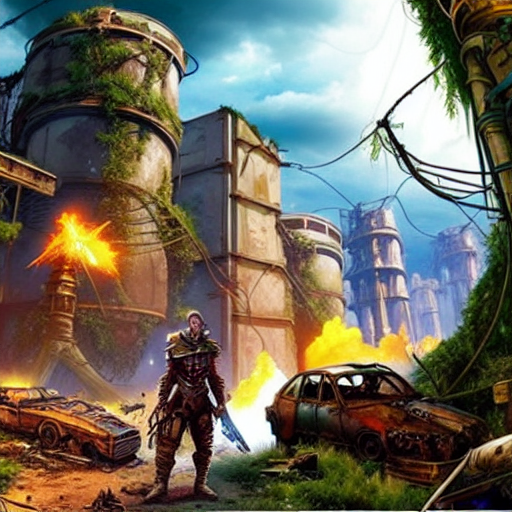

In [11]:
images[0]